In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision

c:\Users\arwml\Py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),      #データ拡張：ランダムに反転   ＊＊＊エポック毎にランダムに違う画像になる。数が増える訳ではない＊＊＊
    transforms.ColorJitter(),               #データ拡張：ランダムに色彩を変える
    transforms.RandomRotation(10),          #データ拡張：ランダムに回転 プラスマイナス１０度
    transforms.Resize((224, 224)),  #画像サイズバラバラなのをリサイズ  Resnet18の入力は224x224 
    transforms.ToTensor(),          #GPUへ (チャネルの並び替え含む)
    transforms.Normalize((0.5, ), (0.5,))          #平均、標準偏差を０．５                      
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),  #画像サイズバラバラなのをリサイズ  Resnet18の入力は224x224 
    transforms.ToTensor(),                 #画像をtensorクラスに変換 チャネルファーストへ入れ替えと値を０－１へ。
    transforms.Normalize((0.5,), (0.5,))   #平均と標準偏差を０．５になるように正規化                               
])


In [4]:
#下位のフォルダごとに画像が分かれている場合はImageFolderで読み込む。 下位フォルダごとにラベル付けされる。
#train_dataset = datasets.ImageFolder("./mydata/train", transform=transform)  #フォルダから画像をとってくる
train_dataset = datasets.ImageFolder("./data_train", transform=train_transform)    #フォルダから画像をとってくる
valid_dataset = datasets.ImageFolder("./data_valid", transform=valid_transform)    #検証用

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)   #画像をデータローダへ渡す
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True)  #検証用

In [5]:
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
labels

tensor([0, 1, 1, 2, 0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0,
        1, 2, 2, 2, 0, 2, 0, 1])

In [6]:
imgs.size()  #ミニバッチ、チャネル、

torch.Size([32, 3, 224, 224])

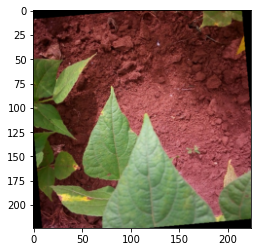

In [7]:
img = imgs[0]
img_permute = img.permute(1, 2, 0)  #チャネルの順番入れ替え
img_permute = 0.5 * img_permute + 0.5  #明るさ調整
img_permute = np.clip(img_permute, 0, 1)   #クリップ
plt.imshow(img_permute)

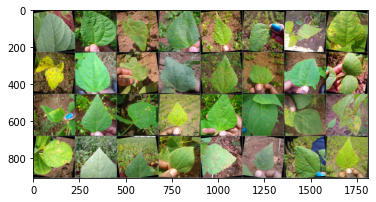

tensor([0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 1,
        1, 0, 0, 2, 1, 2, 2, 1])


In [8]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 訓練データをランダムに取得
dataiter_ = iter(train_loader)
images_, labels_ = dataiter_.next()
imshow(torchvision.utils.make_grid(images_))  # 画像の表示
print(labels_)

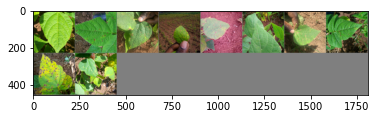

tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 2])


In [9]:
# 検証データをランダムに取得
dataiter_ = iter(valid_loader)
images_, labels_ = dataiter_.next()
imshow(torchvision.utils.make_grid(images_))  # 画像の表示
print(labels_)

In [10]:
model = models.resnet18(pretrained=True)  #学習済みの重みももってくる
#print(model)


In [11]:
# for param in model.parameters():
#     param.requires_grad = False      #False: 勾配計算しない方が高速なので良い？ 

In [11]:
model.fc = nn.Linear(512, 3)   ##モデルの最後のfcを付け替える。  分類する数に合わせる！！
#print(model)

In [12]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
criterion = nn.CrossEntropyLoss()   #2クラス分類
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)    #######ポイント：fcだけ渡す。学習が早い#######

In [14]:
num_epochs = 100
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0   #精度
    for imgs, labels in train_loader:    
        imgs = imgs.to(device)       #GPUへ
        labels = labels.to(device)   #GPUへ
        optimizer.zero_grad()  #オプティマイザ初期化
        output = model(imgs)   #予測を行う
        loss = criterion(output, labels)  
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)   #dim=1はチャネル方向  dim=0はバッチ方向
        running_acc += torch.mean(pred.eq(labels).float())  #判定
        loss.backward()
        optimizer.step()  #重み更新
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    losses.append(running_loss)
    accs.append(running_acc)

    #
    # validation loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in valid_loader:
        val_imgs_back = val_imgs 
        val_labels_back = val_labels
        val_imgs = val_imgs.to(device)      #GPUへ
        val_labels = val_labels.to(device)  
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(valid_loader)
    val_running_acc /= len(valid_loader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {:.4f}, acc: {:.4f},  val loss: {:.4f}, val acc: {:.4f}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

#====== 保存 =======
torch.save(model.state_dict(), "./model.pth")


epoch: 0, loss: 1.0448, acc: 0.4805,  val loss: 0.9358, val acc: 0.4857
epoch: 1, loss: 0.8419, acc: 0.6036,  val loss: 0.8546, val acc: 0.6238
epoch: 2, loss: 0.6843, acc: 0.7516,  val loss: 0.6615, val acc: 0.7095
epoch: 3, loss: 0.5796, acc: 0.7984,  val loss: 0.6445, val acc: 0.7524
epoch: 4, loss: 0.5436, acc: 0.8295,  val loss: 0.5106, val acc: 0.8095
epoch: 5, loss: 0.5341, acc: 0.8218,  val loss: 0.5848, val acc: 0.7190
epoch: 6, loss: 0.4902, acc: 0.8258,  val loss: 0.5394, val acc: 0.7476
epoch: 7, loss: 0.4254, acc: 0.8666,  val loss: 0.4554, val acc: 0.8524
epoch: 8, loss: 0.4028, acc: 0.8773,  val loss: 0.4468, val acc: 0.8571
epoch: 9, loss: 0.4101, acc: 0.8431,  val loss: 0.5590, val acc: 0.7810
epoch: 10, loss: 0.3904, acc: 0.8678,  val loss: 0.4291, val acc: 0.8857
epoch: 11, loss: 0.3753, acc: 0.8817,  val loss: 0.4024, val acc: 0.7952
epoch: 12, loss: 0.3366, acc: 0.8982,  val loss: 0.3369, val acc: 0.9143
epoch: 13, loss: 0.3570, acc: 0.8733,  val loss: 0.4285, val 

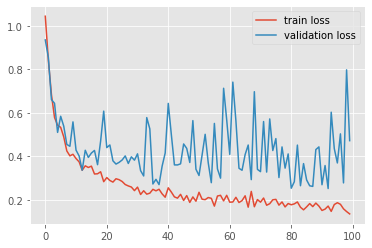

In [15]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()


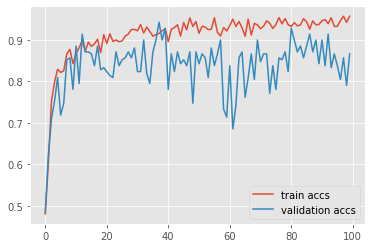

In [16]:

accs_float =[] 
for val in accs:
    accs_float.append(float(val.to('cpu')))       #accsは tensor型のリストなので、float型に変換する

val_accs_float=[]
for val in val_accs:
    val_accs_float.append(float(val.to('cpu')))   #val_accs はtensor型のリストなので、float型に変換する

plt.style.use("ggplot")
plt.plot(accs_float, label="train accs")
plt.plot(val_accs_float, label="validation accs")
plt.legend()


val_labels_back = tensor([2, 2, 2])
val_pred = tensor([2, 2, 1], device='cuda:0')


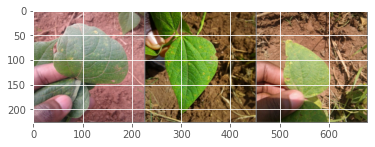

In [17]:
#検証用ミニバッチの最後のサンプルで予測結果を確認 
print(f'val_labels_back = {val_labels_back}')
print(f'val_pred = {val_pred}' )
imshow(torchvision.utils.make_grid(val_imgs_back))  # 画像の表示
